In [1]:
import numpy as np
import camb
from scipy.io import readsav
import matplotlib.pyplot as plt
import matplotlib.cm as cm

## Tools needed to create a map in pixel or Fourier space 

In [2]:
# Creates a pixel or fourier grid based on nx/ny horizontal/vertical pixels with a pixel size of dx/dy, i.e. pixel area = dx*dy.
def make_grid(mapparams, Fourier = False):    
    nx, dx, ny, dy = mapparams
    if Fourier is False:
        x_min, x_max = -nx*dx/2, nx*dx/2 # in arcmins
        y_min, y_max = -ny*dy/2, ny*dy/2 # in arcmins
        # comuting a horizontal and vertical pixel array
        x, y = np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny) # in arcmins
    else:
        # changing from pixel size in arcmin to radians
        dx_rad, dy_rad = np.radians(dx/60.), np.radians(dy/60.) # in radians
        # computing l_x and l_y Fourier components
        x, y = np.fft.fftfreq(nx, dx_rad), np.fft.fftfreq(ny, dy_rad)
        x_min, x_max = min(x), max(x)
        y_min, y_max = min(y), max(y)
        x, y = 2*np.pi*x, 2*np.pi*y
        x_min, x_max = 2*np.pi*x_min, 2*np.pi*x_max
        y_min, y_max = 2*np.pi*y_min, 2*np.pi*y_max    
    
   
    # creating pixel/fourier grid based on horizontal and vertical pixel array
    grid = np.meshgrid(x, y)
    # defining the bounding box that the image will fill
    extent = [x_min, x_max, y_min, y_max]

    
    return grid, extent


# Converts a 1D profile to a 2D map assuming axisymmetry.
def interpolate_to_2d(grid, x, y):  
    X, Y = grid[0], grid[1]
    R = np.hypot(X, Y)
    interp_to_2d = np.interp(R.flatten(), x, y).reshape(R.shape) 
    return interp_to_2d


# Creating a Gaussian realization of a given power spectrum using the flat sky approximation.
def make_gaussian_realization(mapparams, l, psd):  
    # computing the 2D Fourier amplitudes
    nx, dx, ny, dy = mapparams
    dx_rad, dy_rad = np.radians(dx/60.), np.radians(dy/60.)
    
    
    # creating a random Gaussian realisation and its Fourier transform
    gauss_map = np.random.randn(nx, ny)
    gauss_map_fft = np.fft.fft2(gauss_map)
    
    
    
    grid, _ = make_grid(mapparams, Fourier = True)
    if isinstance(psd, list) is False:
        psd2d = interpolate_to_2d(grid, l, psd)
        # noramlization stuff, i.e. taking into account pixel size
        psd2d_sqrt_norm = np.sqrt(psd2d)/np.sqrt(dx_rad * dy_rad)
        psd2d_sqrt_norm[np.isnan(psd2d_sqrt_norm)] = 0.     
        # creating the flat-sky map               
        sim = np.fft.ifft2(psd2d_sqrt_norm*gauss_map_fft).real   
        sim = sim - np.mean(sim)
        return sim
    else:
        sims = []
        for i in range(len(psd)):
            psd2d = interpolate_to_2d(grid, l, psd[i])
            # noramlization stuff, i.e. taking into account pixel size
            psd2d_sqrt_norm = np.sqrt(psd2d)/np.sqrt(dx_rad * dy_rad)
            psd2d_sqrt_norm[np.isnan(psd2d_sqrt_norm)] = 0.
            # creating the flat-sky map               
            sim = np.fft.ifft2(psd2d_sqrt_norm*gauss_map_fft).real   
            sim = sim - np.mean(sim)
            sims.append(sim)
        return sims

## Computing lensed CMB temperature power spectrum using the camb module

In [3]:
def cmb_power_spectrum(h = 0.674, omega_r = 0, ombh2=0.0224, omch2=0.120, omega_k = 0, tau = 0.054, TCMB = 2.72548, As = 2.10e-9, ns=0.965):
    # setting cosmology 
    pars = camb.CAMBparams()
    pars.set_cosmology(H0=100*h, ombh2=ombh2, omch2=omch2, omk=omega_k, tau = tau, TCMB = TCMB)
    pars.InitPower.set_params(As = As, ns=ns)
    pars.set_for_lmax(9949)
    # computing the lensed temperature power spectrum 
    results = camb.get_results(pars)
    powers =results.get_cmb_power_spectra(pars, CMB_unit='muK')
    # extracting lensed temperature power spectrum
    dl = powers['lensed_scalar'][:,0]
    l = np.arange(dl.shape[0])
    cl = dl * 2 * np.pi / (l*(l+1))
    return l, cl

## Creating power spectra of extragalactic foregrounds

In [4]:
# defining relevant constants
c = 3e8  # speed of light in m/s
h = 6.626e-34
k_B = 1.38e-23
T_cmb = 2.72548  # CMB temperature in K
T_cib = 20  # CIB temperature in K
l_norm = 3000
freq0 = 150


# defining some relevant functions used to scale from 150 GHz to any given frequency
#################################################################################################################################
def fn_dB_dT(freq):
    x = (h * freq * 1e9) / (k_B * T_cmb)
    dBdT = x**4. * np.exp(x) / (np.exp(x)-1)**2.
    return dBdT  
    
    
def fn_BnuT(freq, temp):
    x = (h * freq * 1e9) / (k_B * temp)
    t1 = 2 * h * freq**3/ c**2
    t2 = 1./ (np.exp(x)-1.)
    return t1 * t2


def tsz_spec(freq):    
    x = (h * freq * 1e9) / (k_B * T_cmb)
    g_nu = x * (np.exp(x/2) + np.exp(-x/2)) / (np.exp(x/2) - np.exp(-x/2)) - 4.
    return np.mean(g_nu) 


def compton_y_to_delta_Tcmb(freq, uK = False):
    g_nu = tsz_spec(freq)
    scale_fact = g_nu*T_cmb
    if uK is True:
        scale_fact = scale_fact*1e6
    return scale_fact
########################################################################################################

def get_foreground_power_spt(component):
    components = ['tSZ', 'DG-Cl','DG-Po','RG', 'kSZ']
    filename = 'sim_data/george_plot_bestfit_line.sav'
    data = readsav(filename)
    freqs = np.asarray([(95, 95), (95, 150), (95, 220), (150, 150), (150, 220), (220, 220)])
    dl_all = data['ml_dls'][(freqs[:, 0] == 150) & (freqs[:, 1] == freq0)][0]
    labels = data['ml_dl_labels'].astype('str')
    el = np.asarray(data['ml_l'], dtype=int)
    spec = dl_all[labels == component][0]

    # pad to l=0
    spec = np.concatenate((np.zeros(min(el)), spec))
    el = np.concatenate((np.arange(min(el)), el))

    el = el[:10000]
    spec = spec[:10000]

    return el, spec


def get_cl_radio(freq1, freq2 = None):
    
    if freq2 is None:
        freq2 = freq1
        
    l, dl_rg_freq0 = get_foreground_power_spt('RG')
    epsilon_nu1_nu2 =  (fn_dB_dT(freq0)**2)/(fn_dB_dT(freq1) * fn_dB_dT(freq2))

    dl_rg =  dl_rg_freq0[l == l_norm][0] * epsilon_nu1_nu2 * ((freq1 * freq2)/(freq0**2))**(-0.9) * (l/l_norm)**2
    cl_rg = (2*np.pi)/(l * (l+1))*dl_rg
    cl_rg[np.isnan(cl_rg)] = 0.
    if (freq1>230 or freq2>230):
        cl_rg *= 0.

    return l, cl_rg


def get_cl_cib(freq1, freq2 = None):
    
    if freq2 is None:
        freq2 = freq1
     
    l, dl_po_freq0 = get_foreground_power_spt('DG-Po')
    l, dl_clus_freq0 = get_foreground_power_spt('DG-Cl')
    epsilon_nu1_nu2 = (( fn_dB_dT(freq0) )**2.)/(fn_dB_dT(freq1) * fn_dB_dT(freq2))
    bnu1 = fn_BnuT(freq1, temp = T_cib)
    bnu2 = fn_BnuT(freq2, temp = T_cib)
    bnu0 = fn_BnuT(freq0, temp = T_cib)
    etanu1_po = ((freq1*1e9)**1.505) * bnu1
    etanu2_po = ((freq2*1e9)**1.505) * bnu2
    etanu0_po = ((freq0*1e9)**1.505) * bnu0
    etanu1_clus = ((freq1*1e9)**2.51) * bnu1
    etanu2_clus = ((freq2*1e9)**2.51) * bnu2
    etanu0_clus = ((freq0*1e9)**2.51) * bnu0

    
    dl_po = dl_po_freq0[l == l_norm][0] * epsilon_nu1_nu2 * ((etanu1_po * etanu2_po)/(etanu0_po**2)) * (l/l_norm)**2
    dl_clus = dl_clus_freq0[l == l_norm][0] * epsilon_nu1_nu2 * ((etanu1_clus * etanu2_clus)/(etanu0_clus**2)) * (l/l_norm)**0.8
    dl_cib = dl_po + dl_clus
    cl_cib =  (2*np.pi)/(l * (l+1)) * dl_cib 
    cl_cib[np.isnan(cl_cib)] = 0.
    cl_cib[np.isinf(cl_cib)] = 0.

    return l, cl_cib


def get_cl_tsz(freq1, freq2 = None):
    l, dl_tsz_freq0 = get_foreground_power_spt('tSZ')

    tsz_fac_freq0 = tsz_spec(freq0)
    tsz_fac_freq1 = tsz_spec(freq1)
    tsz_fac_freq2 = tsz_spec(freq2)


    dl_tsz = dl_tsz_freq0 * tsz_fac_freq1 * tsz_fac_freq2/ (tsz_fac_freq0**2.)
    cl_tsz =  (2*np.pi)/(l * (l+1)) * dl_tsz
    cl_tsz[np.isnan(cl_tsz)] = 0.
    cl_tsz[np.isinf(cl_tsz)] = 0.

    return l, cl_tsz



def get_cl_ksz():
    
    l, dl_ksz_freq0 = get_foreground_power_spt('kSZ')
    cl_ksz =  (2*np.pi)/(l * (l+1)) * dl_ksz_freq0
    cl_ksz[np.isnan(cl_ksz)] = 0.
    cl_ksz[np.isinf(cl_ksz)] = 0.
    
    return l, cl_ksz

def get_cl_tsz_cib(freq1, freq2 = None):
    
    if freq2 is None:
        freq2 = freq1
      
    #get tSZ and CIB spectra for freq1
    l, cl_tsz_freq1_freq1 = get_cl_tsz(freq1, freq1)
    l, cl_cib_freq1_freq1 = get_cl_cib(freq1, freq1)
    
 
    #get tSZ and CIB spectra for freq2
    l, cl_tsz_freq2_freq2 = get_cl_tsz(freq2, freq2)
    l, cl_cib_freq2_freq2 = get_cl_cib(freq2, freq2)
    
    cl_tsz_cib =  - 0.1 * ( np.sqrt(cl_tsz_freq1_freq1 * cl_cib_freq2_freq2) + np.sqrt(cl_tsz_freq2_freq2 * cl_cib_freq1_freq1) )

    return l, cl_tsz_cib


# function which returns the sum of given components
def extragalactic_power_spectrum(freq, freq2 = None, components = 'all'):
    
    if freq2 is None:
        freq2 = freq
    
    if components == 'all':
        components = ['radio', 'cib', 'tsz', 'ksz', 'tsz_cib']
  
    cl_extragal = np.zeros(10000)
    if 'radio' in components:
        l, cl_radio = get_cl_radio(freq, freq2)
        cl_extragal += cl_radio
    if 'cib' in components:   
        l,  cl_cib = get_cl_cib(freq, freq2)
        cl_extragal += cl_cib
    if 'tsz' in components:   
        l,  cl_tsz = get_cl_tsz(freq, freq2)
        cl_extragal += cl_tsz
    if 'ksz' in components:   
        l,  cl_ksz = get_cl_ksz()
        cl_extragal += cl_ksz    
    if 'tsz_cib' in components:   
        l,  cl_tsz_cib = get_cl_tsz_cib(freq, freq2)
        cl_extragal += cl_tsz_cib
    
    return l, cl_extragal

## Convolving an image with a Gaussian beam.

In [5]:
def beam_power_spectrum(beam_fwhm):
    l = np.arange(10000)
    fwhm_radians = np.radians(beam_fwhm/60)
    sigma = fwhm_radians / np.sqrt(8. * np.log(2.))
    bl = np.exp(-1 * l * (l+1) * sigma ** 2)  
    return l, bl

In [6]:
def gaussian_filter(mapparams, image, ell, bl):
    # computing the 2D beam power spectrum
    grid, _ = make_grid(mapparams, Fourier = True)
    bl2d = interpolate_to_2d(mapparams, ell, np.sqrt(bl)) 
    
    
    # convolving the image 
    image_fft = np.fft.fft2(image) 
    smoothed_image = np.fft.ifft2(image_fft * bl2d).real
    
    
    return smoothed_image

## Creating white noise power spectrum based on noise value in uK-arcmin.

In [7]:
def white_noise_power_spectrum(noiseval_white): 
    l = np.arange(10000)
    # changing from uK-arcmin to uK-radians
    delta_T_radians = np.radians(noiseval_white/60.)
    # creating the white noise power spectrum, i.e. a horizontal line with a y-axis value of delta_T squared
    nl = np.tile(delta_T_radians**2., int(max(l)) + 1 )
    return l, nl 

## Creating realisitc CMB maps using flat sky approximation

In [26]:
def cmb_mock_data(mapparams, l, cl, nber_ch = 1, cl_extragal_arr = None, bl_arr = None, nl_arr = None):
    nx, dx, ny, dy = mapparams
    sim = make_gaussian_realization(mapparams, l, cl)
    sims_ch_arr = [sim for k in range(nber_ch)]
    if cl_extragal_arr is not None:
        extragal_maps = make_gaussian_realization(mapparams, l, cl_extragal_arr)
        for j in range(nber_ch):
            sims_ch_arr[j] += extragal_maps[j]
    if bl_arr is not None:
        for j in range(nber_ch):    
            sims_ch_arr[j] = gaussian_filter(mapparams, sims_ch_arr[j], l, bl_arr[j])
    if nl_arr is not None:
        for j in range(nber_ch):
            noise_map = make_gaussian_realization(mapparams, l, nl_arr[j])
            sims_ch_arr[j] += noise_map
    if nber_ch == 1:
        sims_ch_arr = sims_ch_arr[0]
    return sims_ch_arr 

## Computing some example maps at different frequencies

In [28]:
mapparams = [240, 0.25, 240, 0.25] # this will give us a 240*(0.25 arcmin)X240*(0.25 arcmin) = (60 arcmin X 60 arcmin) map
l, cl = cmb_power_spectrum()
# using frequencies, beam and noise values of SPT3G
l, cl_extragal_90 = extragalactic_power_spectrum(90) # obtain total extragalactic auto power at 90 GHz
l, cl_extragal_150 = extragalactic_power_spectrum(150) # obtain total extragalactic auto power at 150 GHz
l, cl_extragal_220 = extragalactic_power_spectrum(220) # obtain total extragalactic auto power at 220 GHz
cl_extragal_arr = [cl_extragal_90, cl_extragal_150, cl_extragal_220]
l, bl_90 =  beam_power_spectrum(beam_fwhm = 1.7)
l, bl_150 =  beam_power_spectrum(beam_fwhm = 1.2)
l, bl_220 =  beam_power_spectrum(beam_fwhm = 1.0)
bl_arr = [bl_90, bl_150, bl_220]
l, nl_90 = white_noise_power_spectrum(noiseval_white = 3.0)
l, nl_150 = white_noise_power_spectrum(noiseval_white = 2.2)
l, nl_220 = white_noise_pwer_spectrum(noiseval_white = 8.8)
nl_arr = [nl_90, nl_150, nl_220]


cmb_maps = cmb_mock_data(mapparams, l, cl, nber_ch = 3, cl_extragal_arr = cl_extragal_arr, bl_arr = bl_arr, nl_arr = nl_arr)

/Users/kevinlevy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/Users/kevinlevy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: divide by zero encountered in true_divide
/Users/kevinlevy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:69: RuntimeWarning: invalid value encountered in multiply
/Users/kevinlevy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: divide by zero encountered in true_divide
/Users/kevinlevy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:99: RuntimeWarning: invalid value encountered in multiply
/Users/kevinlevy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: divide by zero encountered in true_divide
/Users/kevinlevy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:115: RuntimeWarning: invalid value encountered in m

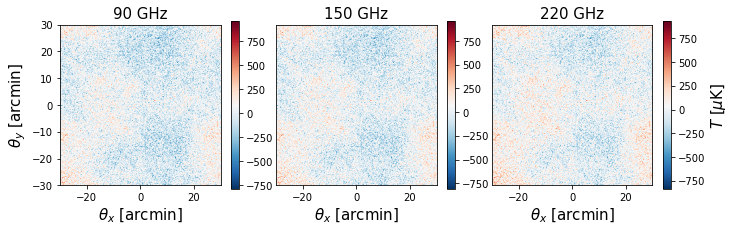

In [29]:
_, extent = make_grid(mapparams)
plt.figure(figsize=(10,10))

fig = plt.subplot(1, 3, 1)
plt.title('90 GHz', fontsize = '15')
plt.imshow(cmb_maps[0], extent = extent, cmap = cm.RdBu_r)
plt.colorbar(shrink = 0.234)
plt.xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
plt.ylabel(r'$\theta_y\ $'+'[arcmin]', fontsize = '15')

fig = plt.subplot(1, 3, 2)
plt.title('150 GHz', fontsize = '15')
plt.imshow(cmb_maps[1], extent = extent, cmap = cm.RdBu_r)
plt.colorbar(shrink = 0.234)
plt.xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
fig.axes.get_yaxis().set_visible(False)
plt.tight_layout(pad=0)

fig = plt.subplot(1, 3, 3)
plt.title('220 GHz', fontsize = '15')
plt.imshow(cmb_maps[2], extent = extent, cmap = cm.RdBu_r)
plt.colorbar(shrink = 0.234).set_label(label=r'$T \ [\mu$'+'K]', size=15)
plt.xlabel(r'$\theta_x\ $'+'[arcmin]', fontsize = '15')
fig.axes.get_yaxis().set_visible(False)
plt.tight_layout(pad=0)

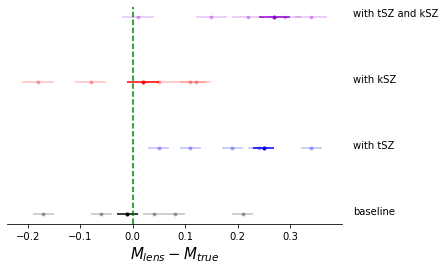

In [30]:
baseline_recov_mass = [5.94, 6.21, 5.83, 6.04, 6.08]
test1_recov_mass = [6.24, 6.11, 6.05, 6.34, 6.19]
test2_recov_mass = [5.92, 6.11, 5.82, 6.12, 6.05]
test3_recov_mass = [6.34, 6.01, 6.15, 6.29, 6.22]


baseline_error = [0.02, 0.02, 0.02, 0.02, 0.02]
test1_error = [0.02, 0.02, 0.02, 0.02, 0.02]
test2_error = [0.03, 0.03, 0.03, 0.03, 0.03]
test3_error = [0.03, 0.03, 0.03, 0.03, 0.03]

centers_baseline = (np.asarray(baseline_recov_mass)-6)#/np.asarray(baseline_error)
centers1  = (np.asarray(test1_recov_mass)-6)#/np.asarray(test1_error)
centers2 = (np.asarray(test2_recov_mass)-6)#/np.asarray(test2_error)
centers3 = (np.asarray(test3_recov_mass)-6)#/np.asarray(test3_error)


fig, ax = plt.subplots()
centers = [centers_baseline, centers1, centers2, centers3]
best_fit_arr = [baseline_recov_mass, test1_recov_mass, test2_recov_mass, test3_recov_mass]
width_arr = [baseline_error, test1_error, test2_error, test3_error]
color_arr = ['black', 'blue', 'red', 'darkviolet']
for cntr, (center, widthval, colorval) in enumerate(zip(centers, width_arr, color_arr )):
    yval = [cntr for i in range(5)]
    plt.errorbar(center, yval, xerr = widthval, color = colorval, marker = '.', ls = '', alpha = 0.25)
plt.errorbar(5.99-6, 0, xerr = 0.02, color = 'black', marker = '.', ls = '')
plt.errorbar(6.25-6, 1, xerr = 0.02, color = 'blue', marker = '.', ls = '')
plt.errorbar(6.02-6, 2, xerr = 0.03, color = 'red', marker = '.', ls = '')
plt.errorbar(6.27-6, 3, xerr = 0.03, color = 'darkviolet', marker = '.', ls = '')
plt.axvline(0, color = 'green', ls = '--')
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.axes.yaxis.set_ticks([])
plt.text(0.42, 0, 'baseline')
plt.text(0.42, 1, 'with tSZ')
plt.text(0.42, 2, 'with kSZ')
plt.text(0.42, 3, 'with tSZ and kSZ')
plt.xlabel(r'$M_{lens}-M_{true}$', fontsize = 15)
plt.show()

In [48]:
fname = 'sim_data/mdpl2_cutouts_for_tszksz_clus_detection_M1.7e+14to2.3e+14_z0.6to0.8_15320haloes_boxsize20.0am.npz'
cutouts_dic = np.load(fname, allow_pickle = 1, encoding= 'latin1')['arr_0'].item()
mass_z_key = list(cutouts_dic.keys())[0]
cutouts = cutouts_dic[mass_z_key]
scale_fac = fg.compton_y_to_delta_Tcmb(freq = 150, uK = True)
v_cutouts, ksz_cutouts, cluster_corr_cutouts = [], [], []
for kcntr, keyname in enumerate( cutouts ):
    v_cutouts.append(cutouts[keyname]['y']*scale_fac)
    ksz_cutouts.append(cutouts[keyname]['ksz'])

In [49]:
tsz_arr = []
for i in range(3000):
    tsz = v_cutouts[i]
    tsz_arr.append(tsz)

In [50]:
print(len(v_cutouts))

15320


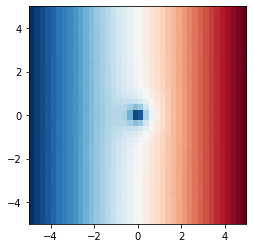

In [60]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
grid, extent = tools.make_grid([40, 0.25, 40, 0.25])
plt.imshow(np.mean(tsz_arr, axis = 0)+10*grid[0],extent = extent, cmap = cm.RdBu_r)

In [63]:
mapparams = [240, 0.25, 240, 0.25]
l, cl = cmb_power_spectrum()
l, bl =  beam_power_spectrum(beam_fwhm = 1.4)
l, nl = white_noise_power_spectrum(noiseval_white = 2.0)
sim = make_gaussian_realization(mapparams, l, cl)
sim = gaussian_filter(mapparams, sim, l, bl)
noise_map = make_gaussian_realization(mapparams, l, nl)
sim+=noise_map

/Users/kevinlevy/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]


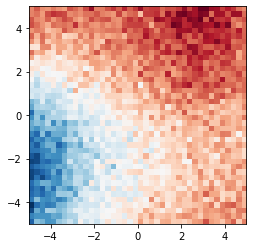

In [65]:
plt.imshow(sim[100:140, 100:140], extent = extent, cmap = cm.RdBu_r)